In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import scipy.sparse as ss
%matplotlib inline

plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
UIMatrix = np.load('UIMatrix.npy')[1:, :]
# UIMatrix = ss.csr_matrix(UIMatrix)
UIMatrix

array([[4, 0, 4, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [2, 2, 2, ..., 0, 0, 0],
       [3, 0, 0, ..., 0, 0, 0],
       [5, 0, 0, ..., 0, 0, 0]])

In [103]:
# 逐元素
X = UIMatrix.copy()[:200, :600]
# X = np.array([[5, 3, 0, 1],
#               [4, 0, 0, 1],
#               [1, 0, 0, 4],
#               [0, 1, 5, 4],
#               [0, 1, 5, 4]])

def mf2(loss):
    n, m = X.shape
    k = 32 # 隐空间大小(试出来的)
    row, col, val = ss.find(X)

    step = 8e-4
    eps = 1e-3
    lam = 0.08  # 正则化系数

    # 划分训练集，测试集
    train_test_rate = 0.15
    ziprc = np.array((row, col, val)).T
    np.random.shuffle(ziprc)
    test = ziprc[:int(ziprc.shape[0] * train_test_rate), :]
    train = ziprc[int(ziprc.shape[0] * train_test_rate):, :]

    # 初始化
    P = np.random.rand(n, k)  # 初始化用户矩阵
    Q = np.random.rand(k, m)  # 初始化商品矩阵

    train_x = list(train[:, 0])
    train_y = list(train[:, 1])

    max_iter = int(8e4)
    lossi_old = 1e6
    for _ in range(max_iter):
        lossi = 0
        for i, j in zip(train_x, train_y):
            eij = X[i, j] - np.dot(P[i, :], Q[:, j])
            for u in range(k):
                P[i, u] += (eij * Q[u, j]-lam*P[i,u]) * step
                Q[u, j] += (eij * P[i, u]-lam*Q[u,j]) * step
            lossi += eij ** 2+lam*(np.dot(P[i,:],P[i,:])+np.dot(Q[:,j],Q[:,j]))
        loss.append(lossi*0.5)
        if np.abs(lossi - lossi_old) < eps:
            break
        lossi_old = lossi
        if _ % 500 == 0:
            print(lossi)
    return P, Q, test


loss = []
P, Q, test = mf2(loss)
loss1 = np.array(loss)
print(loss[-10:])
print(len(loss))
plt.plot(range(len(loss)), loss)
plt.show()

np.save('全批量，无正则化，固定步长loss', loss1)
np.save('全批量，无正则化，固定步长P', P)
np.save('全批量，无正则化，固定步长Q', Q)
np.save('全批量，无正则化，测试集', test)

84130.21718036284
5470.974786435184
5074.88671089121
4934.481293536378
4862.153065331288
4817.165357066648
4786.181587103849
4763.50414582451
4746.2188897884525
4732.65044929299
4721.75694524043
4712.852819163708
4705.467254436579
4699.265817449944
4694.004304550476
4689.500202122072
4685.614355492237
4682.238829491801
4679.288654421363
4676.696076482938
4674.406461582232
4672.375316606454
4670.566083904437
4668.9484828454115
4667.497246267908
4666.1911468300195
4665.01223917429
4663.945264621495


KeyboardInterrupt: 

In [102]:
print(X)
P @ Q

[[4 0 4 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [3 0 0 ... 0 0 0]]


array([[4.06565267, 3.67987387, 4.03130474, ..., 3.27553426, 2.93078491,
        3.04726625],
       [3.51474317, 3.43111879, 3.99750637, ..., 2.68612836, 2.35153744,
        2.4774732 ],
       [2.30867815, 2.19996325, 2.54863573, ..., 2.14898279, 1.5680776 ,
        1.79044182],
       ...,
       [3.00381055, 3.02210075, 3.60030231, ..., 3.35136221, 2.80792696,
        2.29467249],
       [3.69910933, 2.97673026, 2.99845926, ..., 2.02676001, 1.97761081,
        2.15010291],
       [3.45972627, 3.04062855, 3.63097592, ..., 3.07445137, 1.94816766,
        2.46009674]])

In [97]:
test_x = list(test[:, 0])
test_y = list(test[:, 1])
for i, j in zip(test_x, test_y):
    r_ij = X[i, j]
    r_ij_hat = np.around(P[i, :].T @ Q[:, j])
    lossi = (r_ij - r_ij_hat)
    print("r_ij:",r_ij, " r_ij_hat:", r_ij_hat, " loss:", lossi)

r_ij: 4  r_ij_hat: 3.0  loss: 1.0
r_ij: 3  r_ij_hat: 3.0  loss: 0.0
r_ij: 3  r_ij_hat: 3.0  loss: 0.0
r_ij: 4  r_ij_hat: 4.0  loss: 0.0
r_ij: 4  r_ij_hat: 3.0  loss: 1.0
r_ij: 2  r_ij_hat: 3.0  loss: -1.0
r_ij: 5  r_ij_hat: 4.0  loss: 1.0
r_ij: 4  r_ij_hat: 3.0  loss: 1.0
r_ij: 4  r_ij_hat: 4.0  loss: 0.0
r_ij: 2  r_ij_hat: 2.0  loss: 0.0
r_ij: 4  r_ij_hat: 4.0  loss: 0.0
r_ij: 3  r_ij_hat: 3.0  loss: 0.0
r_ij: 4  r_ij_hat: 3.0  loss: 1.0
r_ij: 4  r_ij_hat: 4.0  loss: 0.0
r_ij: 4  r_ij_hat: 3.0  loss: 1.0
r_ij: 3  r_ij_hat: 4.0  loss: -1.0
r_ij: 2  r_ij_hat: 4.0  loss: -2.0
r_ij: 4  r_ij_hat: 4.0  loss: 0.0


用户矩阵P
商品矩阵Q
正则化系数$\lambda$
步长$\epsilon$
迭代公式：
$$
P_{u\times k} = (1-\epsilon \lambda)P + \epsilon E_{u\times i}Q^T \\
Q_{k\times i} = (1-\epsilon \lambda)Q + \epsilon P^TE_{u\times i}
$$

128.69047551292698
106.74203155576197
91.51330692231667
80.20122967212404
71.36807140471
64.24560788670412
58.3909513239715
53.521921307857326
49.44018434260376
45.99567126727625
43.0697599403505
40.5667459309342
38.40890944155689
36.53316464458493
34.888469632116454
33.43368047557925
32.13573232317073
30.96810026892092
29.909511812420508
28.942884806632936
28.054463175296995
27.233121850595698
26.469813257309248
25.757129936010816
25.08896096149471
24.46022315097607
23.866651308011527
23.30463470288924
22.771089552733287
!
[22.363956238857007, 22.36295547569009, 22.36195480820213, 22.360954236375463, 22.359953760192454, 22.358953379635413, 22.357953094686724, 22.356952905328733, 22.35595281154382, 22.354952813314323]
14409


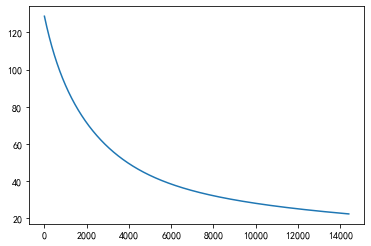

In [21]:
# 全批量，无正则化，固定步长
# 运行时间 150min 9s
# 隐空间维度k
# input:
# X: 评分矩阵
# loss：空列表，用于存储loss,便于画图
def mf(X, loss):
    eps = 1e-3
    step = 8e-6  # 步长
    max_iter = int(1e5)
    n, m = X.shape
    k = int(min(n, m) * 0.6)  # 隐空间大小(试出来的)

    P = np.random.rand(n, k)  # 初始化用户矩阵
    Q = np.random.rand(k, m)  # 初始化商品矩阵
    mask = X != 0
    E = np.where(mask, X - P @ Q, X)  # 初始化

    lossi = 1e4
    for _ in range(max_iter):
        # 更新P,Q,E
        P = P + step * E @ Q.T
        Q = Q + step * P.T @ E
        E = np.where(mask, X - P @ Q, X)
        lossi_old = lossi
        lossi = 0.5 * (np.linalg.norm(E) ** 2)
        loss.append(lossi)
        if _ % 500 == 0:
            print(lossi)
        if np.abs(lossi - lossi_old) <= eps:
            print('!')
            break
    return P, Q


loss = []
P, Q = mf(UIMatrix[1:20, :60], loss)
loss1 = np.array(loss)
np.save('全批量，无正则化，固定步长loss', loss1)
np.save('全批量，无正则化，固定步长P', P)
np.save('全批量，无正则化，固定步长Q', Q)
plt.plot(range(len(loss)), loss)
print(loss[-10:])
print(len(loss))
plt.show()

In [22]:
P @ Q

array([[2.84266778, 2.70356775, 4.16743095, ..., 2.97295834, 2.9680675 ,
        2.18290834],
       [3.36232752, 3.27738361, 3.84310378, ..., 3.00562485, 3.57757915,
        2.88024451],
       [3.44266824, 3.19750026, 2.70460392, ..., 2.3507491 , 2.51180153,
        2.76262354],
       ...,
       [3.77012889, 3.29976018, 3.70743035, ..., 2.94653519, 2.99378291,
        2.80236559],
       [3.2438067 , 2.33429833, 3.24202412, ..., 2.0912004 , 2.60628619,
        2.93757917],
       [4.17003564, 3.63098773, 4.86871575, ..., 3.83287915, 3.81661796,
        3.01000078]])

In [10]:
# 全批量，有正则化，固定步长
# 运行时间 150m 9s
# 隐空间维度k
# input:
# X: 评分矩阵
# loss：空列表，用于存储loss,便于画图
def mf(X, loss):
    eps = 1e-2
    lam = 0.02  # 正则化系数
    step = 8e-6  # 步长
    max_iter = int(1e5)
    n, m = X.shape
    k = int(min(n, m) * 0.6)  # 隐空间大小(试出来的)

    P = np.random.rand(n, k)  # 初始化用户矩阵
    Q = np.random.rand(k, m)  # 初始化商品矩阵
    mask = X != 0
    E = np.where(mask, X - P @ Q, X)  # 初始化

    row, col, val = ss.find(X)

    lossi = 1e4
    for _ in range(max_iter):
        # 更新P,Q,E
        P = P + step * E @ Q.T - lam * step * np.sum(P[row, :], axis=1)
        Q = Q + step * P.T @ E - lam * step * np.sum(Q[:, col], axis=0)
        E = np.where(mask, X - P @ Q, X)
        lossi_old = lossi
        lossi = 0.5 * (np.linalg.norm(E) ** 2 + lam * (np.linalg.norm(P) ** 2 + np.linalg.norm(Q) ** 2))
        loss.append(lossi)
        if _ % 500 == 0:
            print(lossi)
        if np.abs(lossi - lossi_old) <= eps:
            print('!')
            break
    return P, Q


loss = []
P, Q = mf(UIMatrix, loss)
loss1 = np.array(loss)
np.save('全批量，有正则化，固定步长loss', loss1)
np.save('全批量，有正则化，固定步长P', P)
np.save('全批量，有正则化，固定步长Q', Q)
plt.plot(range(len(loss)), loss)
print(loss[-10:])
print(len(loss))
plt.show()

ValueError: operands could not be broadcast together with shapes (611,366) (99466,) 

21340.017727853443
0.0
4.6391103971929
0.0
0.4344161886487749
0.5940329662127002
0.2641612792015787
0.05305840804775939
0.0
0.0
0.0
1.0356660589349242
1.5457950467051977
1.4459151895789848
0.013713868619969692
0.0
0.012871733423281307
0.0
0.46411771887902253
1.194558506597391
1.0607282943500729
0.5486461428505788
5.516889169705756
2.7320246016933885
0.026778687605171502
0.0
0.8193314980706449
2.853110734829111
1.1696793145724753
0.0
0.0
2.9660569790728393
0.3762367172952635
1.054842839425971
0.6330919226164595
0.05443927202756567
0.0
0.8013646349554828
1.6395507537248626
0.0
0.5416754910552735
1.1169708424654146
0.10036461960084553
0.0
0.06453282146611762
2.658840115908166
0.052775888717592284
0.08557040526166217
0.0
0.0530405756825638
2.81110440898683
0.046526801690159665
0.07353672798512291
0.0
0.022779033574517243
0.14047932291090526
0.0024501371961911282
0.9460808113693334
0.021910726799567973
0.0
1.1844340731761585
0.0
0.6026304275700396
0.06583775672485298
0.198776159319042
1.239

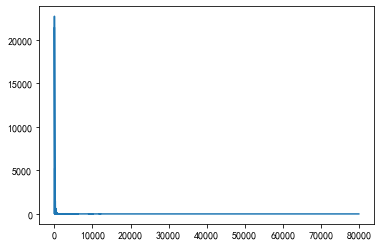

In [6]:
# 小批量，正则化，固定步长
# 19min 52s
def get_batch_index(batchsize, start, N):
    start_old = start
    start = (start_old + batchsize) % N
    if start > start_old:
        index = range(start_old, start)
    else:
        index = [i for i in range(start_old, N)] + [i for i in range(0, start)]
    return index, start


# 隐空间维度k
# input:
# X: 评分矩阵
# loss：空列表，用于存储loss,便于画图
def mf_regular(X, loss):
    eps = 1e-2
    lam = 0  # 正则化系数
    step = 8e-6  # 步长
    max_iter = int(8e4)
    n, m = X.shape
    k = int(min(n, m) * 0.6)  # 隐空间大小(试出来的)
    batch = 128

    P = np.random.rand(n, k)  # 初始化用户矩阵
    Q = np.random.rand(k, m)  # 初始化商品矩阵
    mask = X != 0
    E = np.where(mask, X - P @ Q, X)  # 初始化

    lossi = 1e4
    for _ in range(max_iter):
        # 更新P,Q,E
        P[index_n, :] = (1 - step * lam) * P[index_n, :] + step * E[index_n, :] @ Q.T
        Q[:, index_m] = (1 - step * lam) * Q[:, index_m] + step * P.T @ E[:, index_m]
        E = np.where(mask, X - P @ Q, X)
        lossi_old = lossi
        lossi = 0.5 * (np.linalg.norm(E[index_n, index_m]) ** 2 + lam * (
                np.linalg.norm(P[index_n, :]) ** 2 + np.linalg.norm(Q[:, index_m]) ** 2))
        loss.append(lossi)

        if _ % 500 == 0:
            print(lossi)
    return P, Q


loss = []
P, Q = mf_regular(UIMatrix, loss)
plt.plot(range(len(loss)), loss)
print(loss[-10:])
print(len(loss))
plt.show()

In [9]:
np.round(P @ Q)

array([[78., 76., 82., ..., 90., 94., 92.],
       [ 4.,  4.,  4., ...,  6.,  7.,  5.],
       [ 4.,  3.,  6., ...,  4.,  2.,  4.],
       ...,
       [ 2.,  3.,  2., ...,  3.,  4.,  3.],
       [ 3.,  3.,  6., ...,  5.,  5.,  6.],
       [ 4.,  3.,  3., ...,  4.,  5.,  3.]])